#  Train a model with many observables (no external parameter dependence)


We will train a model which describes the electroweak production of a Z boson in association with 2 jets. We aim to describe many observables simultaneously. This model has no external parameter dependence.

Such a model could be used to perform a goodness-of-fit test to the data, or act as a stochastic generator.


In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import pyplot as plt, colors

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import histo_to_line, plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename, joint_shuffle

from backends import plot as plot, density_model as density_model, VBFZ_analysis as VBFZ


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends



As input we will use 1M electroweak events. We will split this into 70% training and 30% validation data. We will not use a statistically independent test dataset, since we will not evaluate accuracy metrics to assess the model performance. Instead we will study  the ratio between the simulated datapoints and datapoints sampled from the density model.


In [2]:
#  Inputs config

input_fname = "../Data/SM_EWK_1M_rivet_output.pickle"


In [31]:
#  Model config

num_gaussians_per_continuous_observable = 30
max_epochs                              = 500
batch_size                              = 1000
early_stopping_patience                 = 10
early_stopping_min_delta                = 1e-9
validation_split                        = -1

white_linear_fraction_gauss = 0.
whitening_num_points        = 200
whitening_func_form         = "step"
whitening_alpha, whitening_beta, whitening_gamma = 4, 3, 1

load_whitening_funcs = None # ".whitening_funcs_paper_0D_nominal.pickle"    #    ".whitening_funcs_paper_0D.pickle"
save_whitening_funcs = ".whitening_funcs_paper_0D_nominal.pickle"   #    ".whitening_funcs_paper_0D.pickle"

load_model_dir = None                                 #   ".EWK_density_model_paper_0D"
save_model_dir = ".EWK_density_model_paper_0D_GQR1p0"     #   ".EWK_density_model_paper_0D"

learning_rate              = 1e-3       
learning_rate_evo_factor   = 0.5    
learning_rate_evo_patience = 0.5
optimiser     = "adam"       # SGD, Adam or AdaDelta

obs_white_linear_fraction_data_space = {}
obs_white_linear_fraction_data_space ["Dphi_j_j"] = 0.8
obs_white_linear_fraction_data_space ["Dy_j_j"  ] = 0.8
obs_white_linear_fraction_data_space ["m_jj"    ] = 0.2
obs_white_linear_fraction_data_space ["m_ll"    ] = 0.8
obs_white_linear_fraction_data_space ["pT_j1"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_j2"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_jj"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_ll"   ] = 0.2
obs_white_linear_fraction_data_space ["rap_jj"  ] = 0.2
obs_white_linear_fraction_data_space ["rap_ll"  ] = 0.8


In [4]:
#  Configure VBFZ observables
#
remove_observables = ["pT_jj", "N_jets", "N_gap_jets", "m_ll", "Dy_j_j"]
VBFZ.configure(remove_observables)
print(f"Configured with {VBFZ.num_observables} observables: " + ", ".join(VBFZ.observables))
white_linear_fraction_data = [obs_white_linear_fraction_data_space[obs] if obs in obs_white_linear_fraction_data_space else 0. for obs in VBFZ.observables]

#  Configure plot functions with observable information
#
plot.int_observables   = VBFZ.int_observables
plot.observable_limits = VBFZ.transformed_observable_limits


Configured with 7 observables: rap_ll, rap_jj, pT_ll, pT_j2, pT_j1, m_jj, Dphi_j_j


In [5]:
#  Load and format the data
#
data_table = VBFZ.load_table(input_fname)


Loading events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 641867 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 641867 events survived
 -- filtering observ

### Project onto latent space

We will now project the input data onto the latent space on which the density is learned. These objects are stored as dictionaries, where the key labels a tuple of external parameters. Since we don't want to learn any external parameter dependence for this model, we will set this to 1. This acts as a dummy seed for the neural networks.

Note that the first neural network essentially learns a set of constants for the Gaussian parameters, since there is no external parameter dependence. We could achieve this with a simple fit (using Minuit or gradient descent), however we will use a neural network for consistency with the other observables, and accept that this is redundant for the first observable.

Since all subsequent observables are conditioned on all preceeding ones, it is meaningful to use neural networks to capture this dependence. The external parameter value of $1$ is still a dummy variable when we have no external parameter dependence.


In [6]:
#  Load whitening funcs if a file was provided
#  -  this is faster when re-running with the same data and whitening settings later on

whitening_funcs = None
if type(load_whitening_funcs) != type(None) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

    
#  Collect information on axis limits as well as whitening functions, in case new whitening functions 
#     need to be generated
axis_configs = [[VBFZ.transformed_observable_limits[key][0], VBFZ.transformed_observable_limits[key][1], whitening_num_points, white_linear_fraction_data[idx], 0.] for idx, key in enumerate(data_table.keys)]


#  Separate data from weights
true_data, true_data_weights = {}, {}
true_data [1.], true_data_weights [1.] = data_table.get_observables_and_weights()


#  Transform data
print("Transforming data")
transformed_data = {}
transformed_data [1.] = VBFZ.transform_observables_fwd(true_data[1.], data_table.keys)


#  Whiten data
print("Projecting data onto latent space")
white_data = {}
white_data[1.], whitening_funcs = whiten_axes(transformed_data[1.], data_table.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=true_data_weights[1.], 
                                              func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)


#  Save whitening funcs to file, if requested
if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))


Transforming data
Projecting data onto latent space
Saving whitening functions to file .whitening_funcs_paper_0D_nominal.pickle


In [20]:
#  Shuffle data and weights, just to make sure we don't pick up any systematic grouping

true_data[1.], transformed_data[1.], white_data[1.], true_data_weights[1.] = joint_shuffle(true_data[1.], transformed_data[1.], white_data[1.], true_data_weights[1.])


#  Build and fit the density model


In [32]:
#==================================
#===   LOAD / BUILD&FIT MODEL   ===
#==================================

density_model.Gauss_width_reduction_factor = 1.

#  Load model if requested, otherwise build and fit
#
if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #
    #   Figure out the limits of the observables
    #
    white_observables_limits = []
    for obs_idx, (obs_name, obs_type) in enumerate(zip(VBFZ.observables, VBFZ.observable_types)) :
        if obs_type is int :
            white_observables_limits.append([float(x) for x in VBFZ.transformed_observable_limits[obs_name]])
            continue        
        all_data = np.concatenate([item[:,obs_idx] for c,item in white_data.items()])
        min_dp, max_dp = np.min(all_data), np.max(all_data)
        range_dp_per_gauss = (max_dp - min_dp) / num_gaussians_per_continuous_observable
        white_observables_limits.append([min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss]) 
        #white_observables_limits.append([min_dp, max_dp])    
    #
    #   Create density model  
    #
    '''density_model = DensityModel(name               = "EWK_Zjj_density_model"                 , 
                                 num_gaussians      = num_gaussians_per_continuous_observable , 
                                 num_conditions     = 1                                       , 
                                 num_observables    = VBFZ.num_observables                    , 
                                 types              = VBFZ.observable_types                   ,
                                 observables_limits = white_observables_limits                ,
                                 verbose            = True                                    , 
                                 C_float            = 1                                       ,
                                 gauss_mean_scale   = 1./16.                                  ,
                                 gauss_frac_scale   = 1./16.                                  ,
                                 gauss_sigma_scale  = 1./16.                                  ,
                                 optimiser          = "adam"                               ,
                                 learning_rate      = 1e-4                           )'''   # v2
    density_model = DensityModel(name               = "EWK_Zjj_density_model"                 , 
                                 num_gaussians      = num_gaussians_per_continuous_observable , 
                                 num_conditions     = 1                                       , 
                                 num_observables    = VBFZ.num_observables                    , 
                                 types              = VBFZ.observable_types                   ,
                                 observables_limits = white_observables_limits                ,
                                 verbose            = True                                    , 
                                 gauss_mean_scale   = 1./100.                                  ,
                                 gauss_frac_scale   = 1./100.                                  ,
                                 gauss_sigma_scale  = 1./100.                                  ,
                                 optimiser          = optimiser                               ,
                                 learning_rate      = learning_rate                           ,
                                 A1                 = 10                                      ,
                                 A2                 = 0                                       ,
                                 B1                 = 10                                      ,
                                 B2                 = 3                                       ,
                                 C_float            = 1                                       ,
                                 D2                 = 2                                       )
    #
    #   Make sure initial state has no NaN/Inf loss
    #
    density_model.ensure_valid_over_dataset (white_data, true_data_weights)
    #
    #   Fit density model
    #
    density_model.fit(white_data                                           , 
                      true_data_weights                                    ,
                      max_epochs_per_observable = max_epochs               ,
                      early_stopping_patience   = early_stopping_patience  ,
                      early_stopping_min_delta  = early_stopping_min_delta ,
                      validation_split          = validation_split         ,
                      batch_size_per_observable = batch_size               )


INFO       DensityModel.construct      Set model name              : EWK_Zjj_density_model
INFO       DensityModel.construct      Set model num_gaussians     : 30
INFO       DensityModel.construct      Set model num_conditions    : 1
INFO       DensityModel.construct      Set model num_observables   : 7
INFO       DensityModel.construct      Set observable types        : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.build          Building model segment: EWK_Zjj_density_model_observable0 for observable index 0
Creating c

Model: "EWK_Zjj_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_127 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_126 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_615 (Lambda)             (None, 2)            0           input_127[0][0]                  
__________________________________________________________________________________________________
dense_624 (Dense)               (None, 10)           20          input_126[0][0]                  
__________________________________________________________________

Model: "EWK_Zjj_density_model_observable4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_131 (InputLayer)          [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_130 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_633 (Lambda)             (None, 4)            0           input_131[0][0]                  
__________________________________________________________________________________________________
dense_642 (Dense)               (None, 10)           20          input_130[0][0]                  
__________________________________________________________________

Model: "EWK_Zjj_density_model_observable6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_135 (InputLayer)          [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_134 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_651 (Lambda)             (None, 6)            0           input_135[0][0]                  
__________________________________________________________________________________________________
dense_660 (Dense)               (None, 10)           20          input_134[0][0]                  
__________________________________________________________________

641867/641867 [==============================] - 6s 10us/sample - loss: 1.7214e-05
Epoch 9/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7213e-05
Epoch 10/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7212e-05
Epoch 11/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7211e-05
Epoch 12/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7210e-05
Epoch 13/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7210e-05
Epoch 14/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7209e-05
Epoch 15/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7209e-05
Epoch 16/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7209e-05
Epoch 17/500
641867/641867 [==============================] - 6s 10us/sample - loss: 1.7208e-05
Epoch 18/500
641867/641867 [==========================

641867/641867 [==============================] - 7s 11us/sample - loss: 1.5805e-05
Epoch 20/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5804e-05
Epoch 21/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5802e-05
Epoch 22/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5800e-05
Epoch 23/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5799e-05
Epoch 24/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5797e-05
Epoch 25/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5796e-05
Epoch 26/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5795e-05
Epoch 27/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5793e-05
Epoch 28/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5792e-05
Epoch 29/500
641867/641867 [=========================

641867/641867 [==============================] - 9s 14us/sample - loss: 1.5728e-05
Epoch 189/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5727e-05
Epoch 190/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5727e-05
Epoch 191/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5727e-05
Epoch 192/500
641867/641867 [==============================] - 9s 14us/sample - loss: 1.5727e-05
Epoch 193/500
641867/641867 [==============================] - 8s 12us/sample - loss: 1.5727e-05
Epoch 194/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5727e-05
Epoch 195/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.5727e-05
Epoch 196/500
641867/641867 [==============================] - 9s 14us/sample - loss: 1.5727e-05
Epoch 197/500
641867/641867 [==============================] - 8s 13us/sample - loss: 1.5726e-05
Epoch 198/500
641867/641867 [===============

641867/641867 [==============================] - 8s 12us/sample - loss: 4.4878e-06
Epoch 130/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4865e-06
Epoch 131/500
641867/641867 [==============================] - 9s 13us/sample - loss: 4.4842e-06
Epoch 132/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4809e-06
Epoch 133/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4730e-06
Epoch 134/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4774e-06
Epoch 135/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4730e-06
Epoch 136/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4763e-06
Epoch 137/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4683e-06
Epoch 138/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.4700e-06
Epoch 139/500
641867/641867 [===============

641867/641867 [==============================] - 8s 13us/sample - loss: 4.3174e-06
Epoch 298/500
641867/641867 [==============================] - 9s 13us/sample - loss: 4.3160e-06
Epoch 299/500
641867/641867 [==============================] - 9s 15us/sample - loss: 4.3126e-06
Epoch 300/500
641867/641867 [==============================] - 9s 13us/sample - loss: 4.3149e-06
Epoch 301/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.3104e-06
Epoch 302/500
641867/641867 [==============================] - 8s 12us/sample - loss: 4.3090e-06
Epoch 303/500
641867/641867 [==============================] - 8s 12us/sample - loss: 4.3101e-06
Epoch 304/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.3081e-06
Epoch 305/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.3124e-06
Epoch 306/500
641867/641867 [==============================] - 8s 13us/sample - loss: 4.3088e-06
Epoch 307/500
641867/641867 [===============

641867/641867 [==============================] - 8s 13us/sample - loss: 1.4653e-05
Epoch 17/500
641867/641867 [==============================] - 8s 13us/sample - loss: 1.4627e-05
Epoch 18/500
641867/641867 [==============================] - 8s 12us/sample - loss: 1.4602e-05
Epoch 19/500
641867/641867 [==============================] - 8s 13us/sample - loss: 1.4578e-05
Epoch 20/500
641867/641867 [==============================] - 8s 12us/sample - loss: 1.4557e-05
Epoch 21/500
641867/641867 [==============================] - 7s 12us/sample - loss: 1.4540e-05
Epoch 22/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.4524e-05
Epoch 23/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.4508e-05
Epoch 24/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.4494e-05
Epoch 25/500
641867/641867 [==============================] - 8s 12us/sample - loss: 1.4480e-05
Epoch 26/500
641867/641867 [=========================

641867/641867 [==============================] - 7s 12us/sample - loss: 1.4068e-05
Epoch 186/500
641867/641867 [==============================] - 8s 12us/sample - loss: 1.4069e-05
Epoch 187/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.4071e-05
Epoch 188/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.4068e-05
Epoch 189/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.4068e-05
Epoch 190/500
641867/641867 [==============================] - 7s 11us/sample - loss: 1.4068e-05
Epoch 191/500
641867/641867 [==============================] - 8s 12us/sample - loss: 1.4067e-05
Epoch 192/500
641867/641867 [==============================] - 8s 12us/sample - loss: 1.4065e-05
Epoch 193/500
641867/641867 [==============================] - 12s 18us/sample - loss: 1.4065e-05
Epoch 194/500
641867/641867 [==============================] - 11s 17us/sample - loss: 1.4065e-05
Epoch 195/500
641867/641867 [=============

641867/641867 [==============================] - 9s 14us/sample - loss: 1.3993e-05
Epoch 354/500
641867/641867 [==============================] - 9s 14us/sample - loss: 1.3998e-05
Epoch 355/500
641867/641867 [==============================] - 8s 13us/sample - loss: 1.3993e-05
Epoch 356/500
641867/641867 [==============================] - 9s 13us/sample - loss: 1.3991e-05
Epoch 357/500
641867/641867 [==============================] - 9s 13us/sample - loss: 1.3994e-05
Epoch 358/500
641867/641867 [==============================] - 9s 13us/sample - loss: 1.3992e-05
Epoch 359/500
641867/641867 [==============================] - 8s 13us/sample - loss: 1.3991e-05
Epoch 360/500
641867/641867 [==============================] - 9s 14us/sample - loss: 1.3991e-05
Epoch 361/500
641867/641867 [==============================] - 9s 14us/sample - loss: 1.3992e-05
Epoch 362/500
641867/641867 [==============================] - 9s 14us/sample - loss: 1.3992e-05
Epoch 363/500
641867/641867 [===============

641867/641867 [==============================] - 8s 13us/sample - loss: -5.2133e-06
Epoch 115/500
641867/641867 [==============================] - 9s 14us/sample - loss: -5.2169e-06
Epoch 116/500
641867/641867 [==============================] - 9s 13us/sample - loss: -5.2384e-06
Epoch 117/500
641867/641867 [==============================] - 8s 13us/sample - loss: -5.2221e-06
Epoch 118/500
641867/641867 [==============================] - 9s 13us/sample - loss: -5.2411e-06
Epoch 119/500
641867/641867 [==============================] - 9s 14us/sample - loss: -5.2419e-06
Epoch 120/500
641867/641867 [==============================] - 9s 13us/sample - loss: -5.2342e-06
Epoch 121/500
641867/641867 [==============================] - 8s 13us/sample - loss: -5.2632e-06
Epoch 122/500
641867/641867 [==============================] - 9s 13us/sample - loss: -5.2659e-06
Epoch 123/500
641867/641867 [==============================] - 9s 14us/sample - loss: -5.2665e-06
Epoch 124/500
641867/641867 [=====

In [22]:
#  Use this cell to add training epochs to whichever indices appear undertrained

'''improve_indices   = [2]

for obs_idx in improve_indices :
    density_model.fit(white_data                                           , 
                      true_data_weights                                    ,
                      observable                = obs_idx                  ,
                      max_epochs_per_observable = 100                      ,
                      early_stopping_patience   = 10                       ,
                      early_stopping_min_delta  = 1e-9                     ,
                      validation_split          = -1                       ,
                      batch_size_per_observable = batch_size               )'''


'improve_indices   = [2]\n\nfor obs_idx in improve_indices :\n    density_model.fit(white_data                                           , \n                      true_data_weights                                    ,\n                      observable                = obs_idx                  ,\n                      max_epochs_per_observable = 100                      ,\n                      early_stopping_patience   = 10                       ,\n                      early_stopping_min_delta  = 1e-9                     ,\n                      validation_split          = -1                       ,\n                      batch_size_per_observable = batch_size               )'

In [33]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [34]:
#  Generate a large number of datapoints at 0.
#

n_gen = 1000000

print(f"Generating {n_gen} fake datapoints")
start = time.time()
fake_white_datapoints = density_model.sample(n_gen, [1.], n_processes=8)
end = time.time()
print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints")
start = time.time()
fake_transformed_datapoints = unwhiten_axes(fake_white_datapoints, whitening_funcs)
fake_datapoints = VBFZ.transform_observables_back(fake_transformed_datapoints, data_table.keys)
end = time.time()
print(f"{n_gen} datapoints unwhitened in {int(end-start):.0f}s")


Generating 1000000 fake datapoints
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 3
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 4
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 5
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 6
1000000 datapoints generated in 1015s
Unwhitening fake datapoints
1000000 datapoints unwhitened in 51s


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


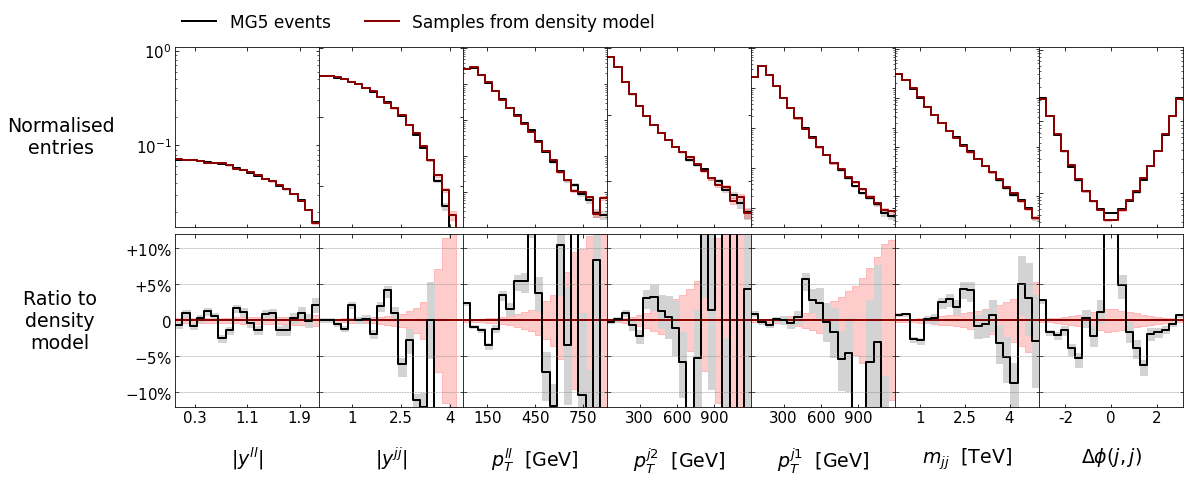

In [35]:
##  TODO: Fix tick marks on y-axis


def plot_1D_projections (plot_observables, save_fname="") :
    
    plot_num_observables = len(plot_observables)

    fig = plt.figure(figsize=(2*plot_num_observables, 5))

    axes1, axes2 = [], []
    ylos , yhis  = [], []

    for plot_idx, observable in enumerate(plot_observables) :

        #  Get axis x coordinates
        xlo    = plot_idx / plot_num_observables
        xwidth = 1.       / plot_num_observables

        #  ============
        #     AXIS 1
        #  ============
        ax1 = fig.add_axes([xlo, 0.50, xwidth, 0.5])

        obs_lims   = VBFZ.observable_limits[observable]
        num_bins   = 20
        if observable in VBFZ.int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 2+(obs_lims[1]-obs_lims[0]))
        else                                  : bins = np.linspace(obs_lims[0], obs_lims[1], num_bins+1)

        obs_idx   = VBFZ.observables.index(observable)
        hvals1, _ = np.histogram(true_data[1.][:,obs_idx], bins=bins, weights=true_data_weights[1.]                      )
        herrs1, _ = np.histogram(true_data[1.][:,obs_idx], bins=bins, weights=true_data_weights[1.]*true_data_weights[1.])
        herrs1    = np.sqrt(herrs1)
        hvals1, herrs1 = hvals1/np.sum(true_data_weights[1.]), herrs1/np.sum(true_data_weights[1.])

        hvals2, _ = np.histogram(fake_datapoints[:,obs_idx], bins=bins)
        herrs2    = np.sqrt(hvals2)
        hvals2, herrs2 = hvals2/len(fake_datapoints), herrs2/len(fake_datapoints)

        plot_x, plot_y1, plot_ey1 = plot.histo_to_line(bins, hvals1, herrs1)
        _     , plot_y2, plot_ey2 = plot.histo_to_line(bins, hvals2, herrs2)

        ax1.plot(plot_x, plot_y1, "-", color="k"      , linewidth=2, label="MG5 events")
        ax1.fill_between(plot_x, plot_y1-plot_ey1, plot_y1+plot_ey1, color="lightgrey", alpha=1)
        ax1.plot(plot_x, plot_y2, "-", color="darkred", linewidth=2, label="Samples from density model")
        ax1.fill_between(plot_x, plot_y2-plot_ey2, plot_y2+plot_ey2, color="red", alpha=0.2)
        ax1.set_yscale("log")

        # Save y values range
        ylo, yhi = np.min([plot_y1-plot_ey1, plot_y2-plot_ey2]), np.max([plot_y1+plot_ey1, plot_y2+plot_ey2])
        ylos.append(ylo)
        yhis.append(yhi)


        #  ============
        #     AXIS 2
        #  ============

        ax2 = fig.add_axes([xlo, 0, xwidth, 0.48])

        ax2.axhline(0, c="darkred", linewidth=2)
        ax2.fill_between(plot_x, -plot_ey2/plot_y2, plot_ey2/plot_y2, color="red", alpha=0.2)
        ax2.plot(plot_x, (plot_y1-plot_y2)/plot_y2, c="k", linewidth=2)
        ax2.fill_between(plot_x, (plot_y1-plot_ey1-plot_y2)/plot_y1, (plot_y1+plot_ey1-plot_y2)/plot_y1, color="lightgrey", alpha=1)
        ax2.set_ylim([-0.12, 0.12])

        for h in [-0.1, -0.05, 0.05, 0.1] :
            ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)

        #  Set y axis tick labels    
        if plot_idx > 0 :
            ax1.get_yaxis().set_ticklabels([])
            ax2.get_yaxis().set_ticklabels([])

        #  Set x axis tick labels
        ax1.get_xaxis().set_ticklabels([])
        ax1.set_xticks(VBFZ.get_obs_ticks(observable))
        ax2.set_xticks(VBFZ.get_obs_ticks(observable))
        ax2.get_xaxis().set_ticklabels(VBFZ.get_obs_ticklabels(observable))

        #  Set x axis labels
        ax2.set_xlabel(VBFZ.get_obs_label(observable), fontsize=19, labelpad=20)

        #  Set y axis labels
        if plot_idx == 0 : 
            ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
            ax2.set_ylabel("Ratio to\ndensity\nmodel", fontsize=19, labelpad=65, rotation=0, va="center")
            ax1.legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)

        #  Set x limits
        ax1.set_xlim([bins[0], bins[-1]])
        ax2.set_xlim([bins[0], bins[-1]])

        #  Set tick params
        ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
        ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

        #  Save axes
        axes1.append(ax1)
        axes2.append(ax2)

    #  Set consistent axis y lims
    for ax in axes1 :
        ax.set_ylim([np.min(ylos)/2., 2.*np.max(yhis)])

    axes2[0].set_yticks     ([-0.1, -0.05, 0, 0.05, 0.1])
    axes2[0].set_yticklabels([r"$-10\%$", r"$-5\%$", r"$0$", r"$+5\%$", r"$+10\%$"])

    if len(save_fname) > 0 :
        plt.savefig(save_fname, bbox_inches="tight")
    plt.show()

plot_1D_projections(VBFZ.observables, f"figures/paper0D_model/1D_distributions_density_model.pdf")

#plot_1D_projections(VBFZ.observables[:6], f"figures/paper0D_model/1D_distributions_density_model_row1.pdf")
#plot_1D_projections(VBFZ.observables[6:], f"figures/paper0D_model/1D_distributions_density_model_row2.pdf")


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/VBFZ_analysis.py:281: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=vmin, vmax=1, norm=colors.LogNorm())


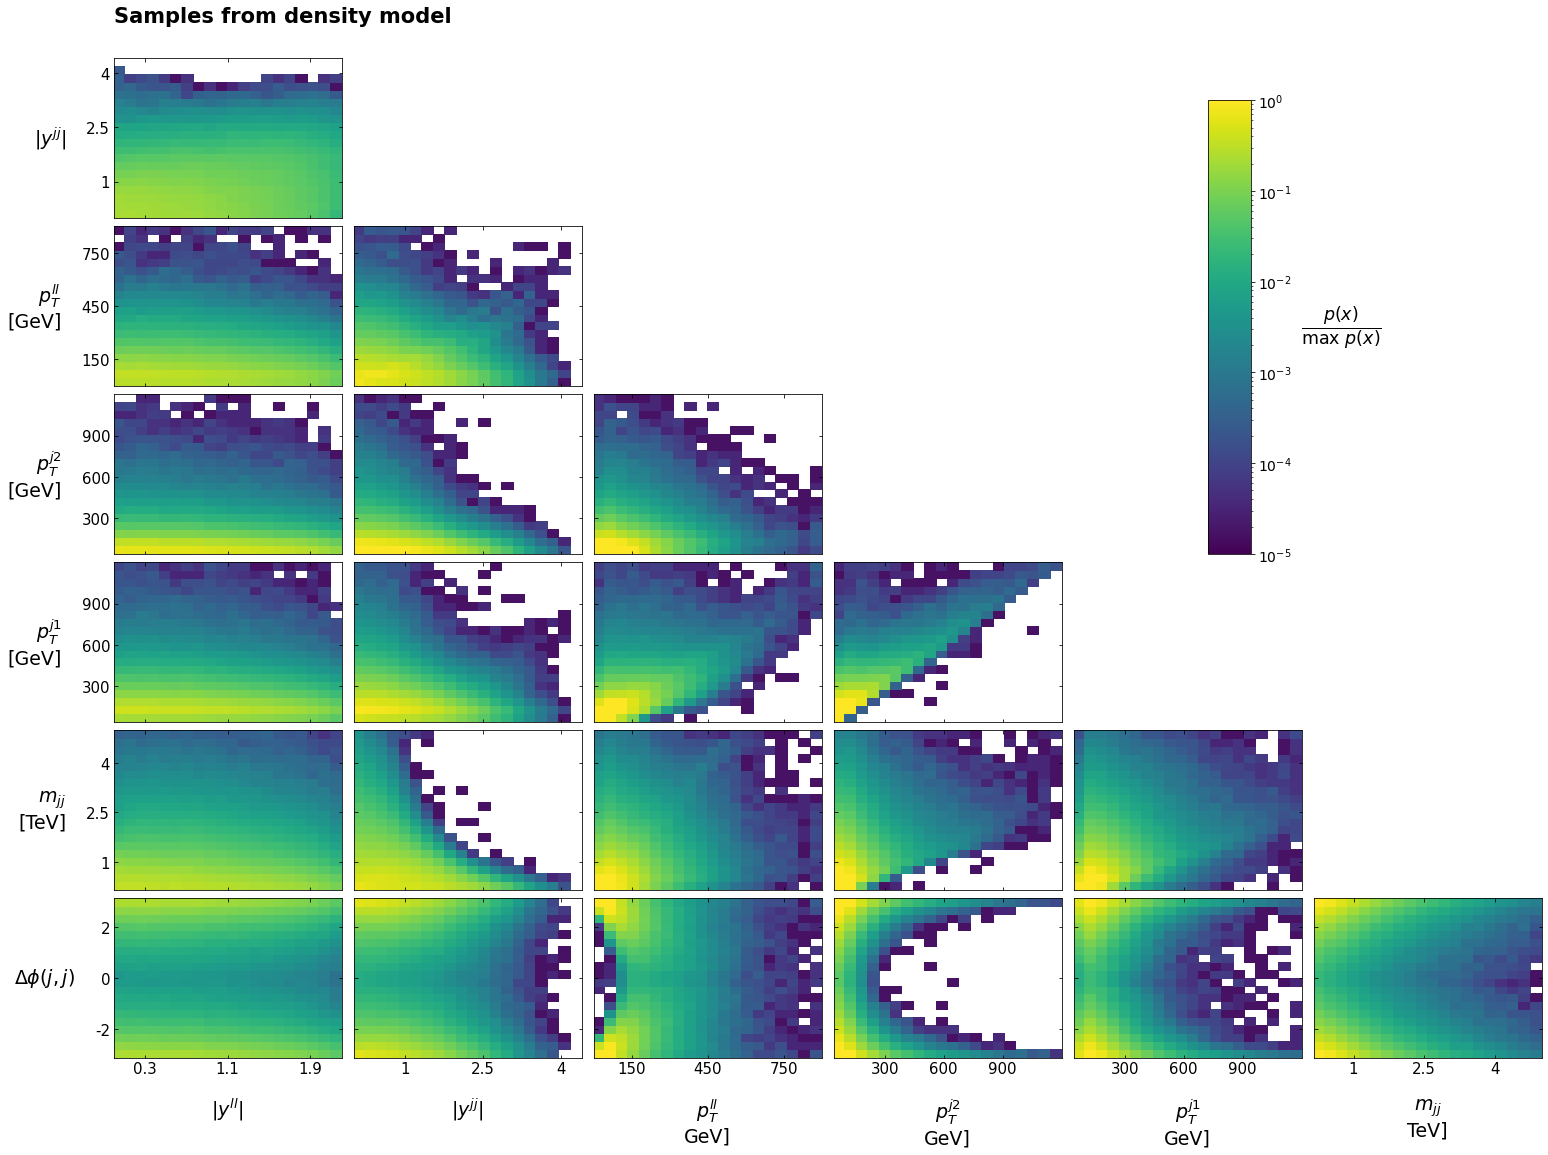

In [36]:

#  Plot generated events

VBFZ.plot_2D_projections(fake_datapoints, label="Samples from density model", savefig=f"figures/paper0D_model/2D_distributions_density_model.pdf")
